# Molecular Dynamics

## Overview

**Questions**
- How does molecular dynamics work?
- What are the limitations of MD methods?

**Objectives**
- Develop an understanding of the fundamentals of molecular dynamics
- Be able to construct a simple one-dimensional MD simulation from scratch

Now that we have introduced the classical methods, and the complications of these methods, we can discuss how the dynamics of the molecules are obtained. 

## Force and acceleration
The particles that we study are classical in nature, and therefore it is possible to apply classical mechanics to rationalise their dynamic behaviour. 
For this the starting point is **Newton's second law of motion**, 

$$ \mathbf{f} = m\mathbf{a}, $$

where $\mathbf{f}$ is the force on an atom of mass, $m$, and acceleration, $\mathbf{a}$. 
The force between two particles, $i$ and $j$, can be found from the interaction energy, 

$$ f_{ij} = \dfrac{-\text{d}E(r_{ij})}{\text{d}r_{ij}}.$$

Which is to say that the force is the negative of the first derivative of the energy with respect to the distance between them.
The code below creates a function that is capable of calculating the energy or the force from the Lennard-Jones potential, depending on the `force` variable. 
Both the energy and force are then plotted on a single graph.

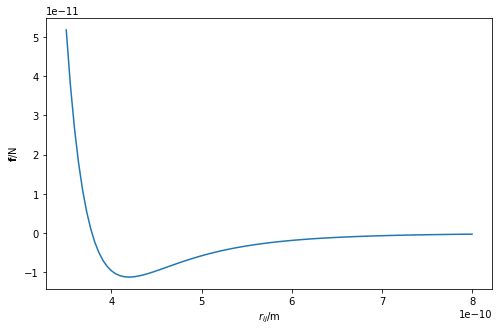

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

def lj(rij, a, b, force):
    """
    Implementation of the Lennard-Jones potential 
    to calculate either the energy or the force.
    
    Parameters
    ----------
    rij: float
        Distance between two particles
    a: float 
        A parameter for interaction
    b: float 
        B parameter for interaction
    force: bool
        If true the force will be determined
    
    Returns
    -------
    float
        Either the energy or the force of the interaction.
    """
    if force:
        return 12 * a / np.power(rij, 13) - 6 * b / np.power(rij, 7)
    else:
        return a / np.power(rij, 12) - b / np.power(rij, 6)
    
r = np.linspace(3.5e-10, 8e-10, 100)
fig = plt.figure(figsize=(8, 5))
ax = fig.add_subplot(111)
ax.plot(r, lj(r, 1.363e-134, 9.273e-78, True))
ax.set_xlabel(r'$r_{ij}$/m')
ax.set_ylabel(r'$\mathbf{f}$/N')
plt.show()

You may have noticed that in Newton's second law of motion, the force is a vector quantity, whereas the force as the negative of the first derivative of the energy is not. 
This means that it is necessary to convert to obtain the force vector for the relevant dimensionality. 
This is achieved by multiplication by the unit vector in each dimension,

$$ \mathbf{f}_x = f\hat{\mathbf{r}}_x\text{, where }\hat{\mathbf{r}}_x = \dfrac{r_x}{|\mathbf{r}|}. $$

In the above equation, $r_x$ is the distance between the two particles in the $x$-dimension and $\mathbf{r}$ is the overall distance vector. 
The above equation must be determined to find the force in each dimension. 
However, this tutorial will only consider particles interacting in a one-dimensional space. 

The code below shows how to determine the acceleration on each atom of argon due to each other atom of argon. 

In [2]:
mass_of_argon = 39.948 # amu
mass_of_argon_kg = mass_of_argon * 1.6605e-27

def get_accelerations(positions):
    """
    Calculate the acceleration on each particle as a 
    result of each other particle. 
    
    Parameters
    ----------
    positions: ndarray of floats
        The positions, in a single dimension, for all
        of the particles
        
    Returns
    -------
    ndarray of floats
        The acceleration on each particle
    """
    rx = np.zeros((positions.size, positions.size))
    accelerationx = np.zeros((positions.size, positions.size))
    for i in range(0, positions.size):
        for j in range(0, positions.size):
            if i != j:
                rx = positions[j] - positions[i]
                rmag = np.sqrt(rx * rx)
                force = lj(rmag, 1.363e-134, 9.273e-78, True)
                forcex = force * rx / rmag
                accelerationx[i, j] = forcex / mass_of_argon_kg
            else:
                accelerationx[i, j] = 0
    return np.sum(accelerationx, axis=0)

accel = get_accelerations(np.array([1e-10, 5e-10, 10e-10]))
print('Acceleration on particle 1 = {:.3e} m/s'.format(accel[0]))
print('Acceleration on particle 2 = {:.3e} m/s'.format(accel[1]))
print('Acceleration on particle 3 = {:.3e} m/s'.format(accel[2]))

Acceleration on particle 1 = 1.463e+14 m/s
Acceleration on particle 2 = -5.736e+13 m/s
Acceleration on particle 3 = -8.891e+13 m/s


## Integration

Now that we understand the position and acceleration of our particles, we can consider applying the Newtonian equations of motion to probe the particles trajectory. 
However, first we must determine the velocity, 

$$ \mathbf{x}_i(t + \Delta t) = \mathbf{x}_i(t) + \mathbf{v}_i(t)\Delta t + \dfrac{1}{2} \mathbf{a}_i(t)\Delta t^2, $$

$$ \mathbf{v}_i(t + \Delta t) = \mathbf{v}_i(t) + \dfrac{1}{2}\big[\mathbf{a}_i(t) + \mathbf{a}_i(t+\Delta t)\big]\Delta t, $$ 

where, $\Delta t$ is the timestep (how far in time is incremented), $\mathbf{x}_i$ is the particle position, $\mathbf{v}_i$ is the velocity, and $\mathbf{a}_i$ the acceleration. 
This pair of equations is known as the Velocity_verlet algorithm, which can be written as:

1. Find the position of the particle after some timestep
2. Calculate the force (and therefore acceleration) on the particle
3. Determine a new velocity for the particle, based on the average acceleration at the current and new positions
4. Overwrite the old acceleration values with the new ones, $\mathbf{a}_i(t) = \mathbf{a}_i(t+\Delta t)$
5. Go to 1

This process can be continued for as long as is required to get good statistics for the quantity you are intereseting in (or for as long as you can wait for/afford to run the computer for). 

The code below is a set of two function for the above equations, these will be applied later.

In [3]:
def update_pos(x, v, a, dt):
    """
    Update the particle positions.
    
    Parameters
    ----------
    x: ndarray of floats
        The positions of the particles in a single dimension
    v: ndarray of floats
        The velocities of the particles in a single dimension
    a: ndarray of floats
        The accelerations of the particles in a single dimension
    dt: float
        The timestep length
    
    Returns
    -------
    ndarray of floats:
        New positions of the particles in a single dimension
    """
    return x + v * dt + 0.5 * a * dt * dt

def update_velo(v, a, a1, dt):
    """
    Update the particle velocities.
    
    Parameters
    ----------
    v: ndarray of floats
        The velocities of the particles in a single dimension
    a: ndarray of floats
        The accelerations of the particles in a single dimension 
        at the previous timestep
    a1: ndarray of floats
        The accelerations of the particles in a single dimension
        at the current timestep
    dt: float
        The timestep length
    
    Returns
    -------
    ndarray of floats:
        New velocities of the particles in a single dimension
    """
    return v + 0.5 * (a + a1) * dt

This process is called the intergration step, and the Velocity-Verlet is the **integrator**. 
In essence, the function that is being integrated is the acceleration on the particular atom at a given time. 
This function is highly non-lineal for more than one particle. 
This means that the integration step will only be valid for every small values of $\Delta t$, e.g. if a large timestep is used the acceleration calculated for that timestep is not accurate as the forces on the atom will change too significantly during it. 
The value for the timestep is usually on the order of 10<sup>-15</sup> s (femtoseconds). 
This means that to even measure a nanosecond of "real-time" molecular dynamics 1 000 000 (one million) iteractions of the above algorithm must be performed. 

## Initialisation

There are only two tools left that you need to run a molecular dynamics simulation, and both are associated with the original configuration of the system; the original particle positions, and the original particle velocities. 

The particle positions are usually either taken from some library of structures (e.g. the protein data bank if you are simulating proteins) or based on some knowledge of the system (e.g. CaF<sub>2</sub> is known to have a face-centred cubic structure). 
The importance of this initial structure cannot be overstated.
For example if the initial structure is very far form the equilibrium structure, it may take a very long time before the equilibrium structure is obtained, possibly much longer than can be reasonably simulated. 

The particle velocities are more general, as the total kinetic energy, $E_K$ of the system (and therefore the particle velocities) are dependent on the temperature of the simulation, $T$. 

$$ E_K = \sum_{i=1}^N \dfrac{m_i|v_i|^2}{2} = \dfrac{3}{2}Nk_BT, $$

where, $m_i$ is the mass of particle $i$, $N$ is the number of particles, and $k_B$ is the Boltzmann constant. 
Based on this knowledge, the most common way to obtain initial velocities is to assign random values and then scale them dependent on the temperature of the system. 
For example, in a common method for the initial velocity determinaiton is as follows, 

$$ v_i = R_i \sqrt{\dfrac{k_BT}{m_i}}, $$

where $R_i$ is some random number between $-0.5$ and $0.5$, $k_B$ is the Boltzmann constant, $T$ is the temperature, and $m_i$ is the mass of the particle.

This method is implemented in the function below. 

In [4]:
from scipy.constants import Boltzmann

def init_velocity(T, number_of_particles):
    """
    Initialise the velocities for a series of particles.
    
    Parameters
    ----------
    T: float
        Temperature of the system at initialisation
    number_of_particles: int
        Number of particles in the system
    
    Returns
    -------
    ndarray of floats
        Initial velocities for a series of particles
    """
    R = np.random.rand(number_of_particles) - 0.5
    return R * np.sqrt(Boltzmann * T / mass_of_argon_kg)

## Build an MD simulation

We can now using the functions defined above build a one-dimensional molecular dynamics simulation. 

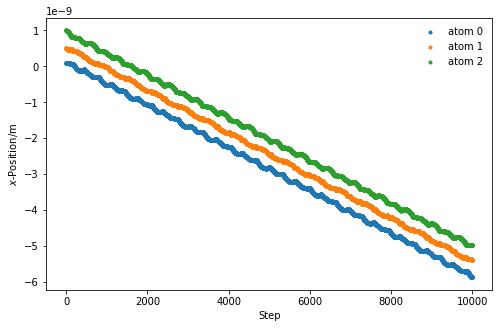

In [5]:
def run_md(dt, number_of_steps, initial_temp, x):
    """
    Run a MD simulation.
    
    Parameters
    ----------
    dt: float
        The timestep length
    number_of_steps: int
        Number of iterations in the simulation
    initial_temp: float
        Temperature of the system at initialisation
    x: ndarray of floats
        The initial positions of the particles in a single dimension
        
    Returns
    -------
    ndarray of floats
        The positions for all of the particles throughout the simulation
    """
    positions = np.zeros((number_of_steps, 3))
    v = init_velocity(initial_temp, 3)
    a = get_accelerations(x)
    for i in range(number_of_steps):
        x = update_pos(x, v, a, dt)
        a1 = get_accelerations(x)
        v = update_velo(v, a, a1, dt)
        a = np.array(a1)
        positions[i, :] = x
    return positions

sim_pos = run_md(1e-14, 10000, 300, np.array([1e-10, 5e-10, 1e-9]))
    
%matplotlib inline
fig = plt.figure(figsize=(8, 5))
ax = fig.add_subplot(111)
for i in range(sim_pos.shape[1]):
    ax.plot(sim_pos[:, i], '.', label='atom {}'.format(i))
ax.set_xlabel(r'Step')
ax.set_ylabel(r'$x$-Position/m')
ax.legend(frameon=False)
plt.show()

If you build the simulation in your own Jupyter Notebook, it is possible to run the simulation at a series of different initial starting positions by varying values in the array `x`. 

## Key Points
- Introduced to the basics of molecular dynamics simulation
- Understand the limitations on the timestep size available to molecular dynamics
- Be able to program a simple one-dimension MD simulation